In [1]:
import numpy as np

# Conjugate Distributions

Conjugate distribution, or conjugate pair, means a pair of a sampling distribution and a prior distribution for which the resulting posterior distribution belongs to the same parametric family of distributions *as the prior distribution*. \
Sometimes it is said that the prior for such pairs is a ***Conjugate Prior***.

A ***Parametric Family*** of distributions is defined as: $$\big\{ f_{Y|\Theta}(y|\theta) : \theta \in \Omega \big\}$$
Written-out, these are sets of distributions which have the same functional form and differ only by the value of a parameter $\theta$ which exists in a finite-dimensional parameter space $\Omega$. 

In the thumbtack-tossing example, the prior distribution was uniform, the sampling distribution was binomial, and the posterior distribution was beta. It turns out that this *was* a conjugate distribution because the uniform distribution is merely a special case of the beta distribution (i.e. $U(0, 1) \equiv B(1, 1)$).

It turns out that there are **only two cases** wherein the marginal likelihood, $f_Y(y)$ may be analytically determined in a closed form:
1. The parameter space is finite-discrete: $\Omega=(\theta_1,...,\theta_p)$. Then the marginal likelihood is the finite sum over the parameter space:
$$f_Y(y) = \sum_{i=1}^p f_{Y|\Theta} (y_i|\theta_i)f_\Theta(\theta_i)$$
2. The prior distribution is a **conjugate prior** for the sampling distribution

## One-Parameter Conjugate Models

## Poisson-Gamma

Assume $Y\sim \text{Poisson}(\lambda)$, then $E[Y] = V[Y] = \lambda$. Let's generate some data (so, assume we know the true parameter value), and then work through inference:

In [8]:
n = 5
lambda_true = 3.0
Y = np.random.poisson(lam=lambda_true, size=n)
Y

array([5, 4, 2, 4, 6], dtype=int32)

Each observation from this process is an IID random variable.\
We know that $\lambda$ may theoretically assume any positive real number. So, a reasonable naive prior for $\lambda$ needs a support of $(0, \infty)$.\
A good candidate is the Gamma distribution, because its support spans $(0, \infty)$, but also because **it is a conjugate prior** with the Poisson distribution.
$$\lambda \sim \text{Gamma}(\alpha, \beta)$$

The likelihood function for the IID RVs in $\bf Y$ is simply the product of the IID Poisson distributions:
$$
p(\mathbf y| \lambda) = \prod_{i=1}^n p(y_i|\lambda) = \prod_{i=1}^\lambda \lambda^{y_i} \frac{e^{-\lambda}}{y_i !}\\ \ \\
\implies p(\mathbf y | \lambda) \propto \lambda^{\sum y_i}e^{-n\lambda} = \lambda^{n\bar y} e^{-n\lambda}
$$

This proportion drops the constant terms ($y_i!$) which do not depend on $\lambda$. This allows us to write the unnormalized posterior distribution as:
$$
p(\lambda|\mathbf y) \propto p(\mathbf y|\lambda) p(\lambda) \\ \ \\
\propto \lambda^{n\bar y}e^{-n\lambda} \lambda^{\alpha - 1}e^{-\beta \lambda} \\ \ \\
= \lambda^{\alpha + n\bar y - 1} e ^{-(\beta + n) \lambda}
$$

This is (proportional to) a gamma distribution defined as: $$\lambda | \mathbf Y \sim \text{Gamma}(\alpha + n \bar y, \ \beta + n)$$
Let's try to plot the prior and posterior distributions...

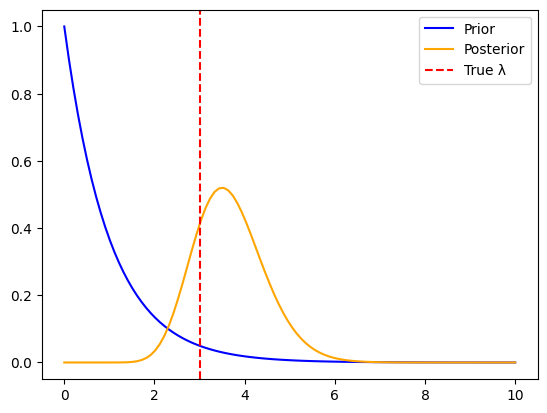

In [21]:
import matplotlib.pyplot as plt
import scipy.stats as stats

alpha = 1
beta = 1

lambda_vals = np.linspace(0, 10, 100)
prior = stats.gamma(a=alpha, scale=1/beta)
posterior = stats.gamma(a=alpha + n * np.mean(Y), scale=1/(beta + n))

def plot_distributions(prior, posterior, lambda_true):
    plt.plot(lambda_vals, prior.pdf(lambda_vals), label='Prior', color='blue')
    plt.plot(lambda_vals, posterior.pdf(lambda_vals), label='Posterior', color='orange')
    plt.axvline(x=lambda_true, color='red', linestyle='--', label='True λ')
    plt.legend()
    plt.show();

plot_distributions(prior, posterior, lambda_true)

The posterior distribution's density is concentrated somewhat above the true value of $\lambda$. This is because the sample data, `[5, 4, 2, 4, 6]` skewed higher than the true value of $3$. Observing a such a sample with only one value less than $3$ was somewhat unlikely, thus the posterior distribution predicts an expected $\lambda$ value conditional on this data that is greater than $3$:

In [20]:
from scipy.stats import poisson
poisson_cdf = poisson.cdf(2, mu=lambda_true)  # P(x <= 2)
print(f"probability of observing 1/5 samples less than 3: {poisson_cdf * (1 - poisson_cdf)**4 * 5:.4f}")  # multiply by 5 for any of the 5 samples being the one less than 3

print(f"Posterior mean: {posterior.mean():.2f}, True λ: {lambda_true}")

probability of observing 1/5 samples less than 3: 0.2342
Posterior mean: 3.67, True λ: 3.0


Let's now enable the posterior distribution to be updated with new data:

initial posterior...


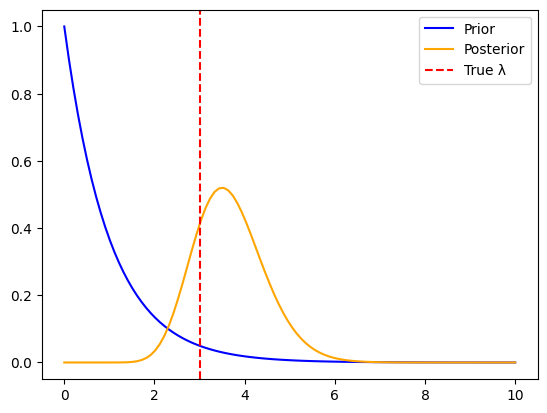

update 1...


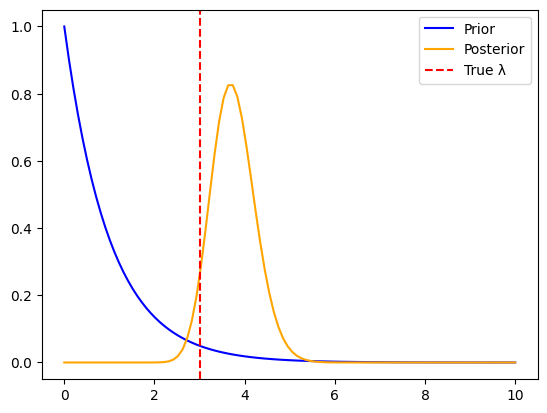

update 2...


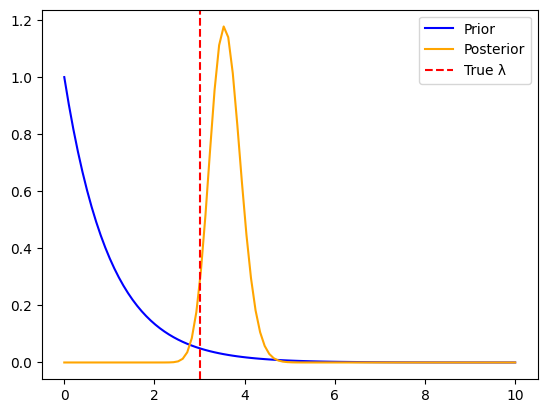

update 3...


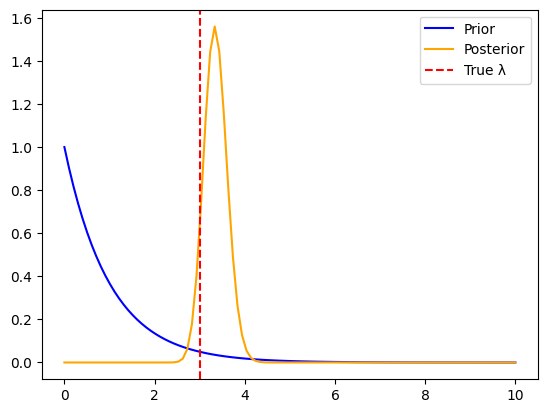

In [25]:
class PosteriorGamma:
    def __init__(self, alpha, beta, data):
        self.data = data
        self.n = len(data)
        self.y_bar = np.mean(data)
        self.alpha = alpha
        self.beta = beta
        self.alpha_post = self.alpha + self.n * self.y_bar
        self.beta_post = self.beta + self.n
        self.dist = stats.gamma(a=self.alpha_post, scale=1/self.beta_post)

    def update(self, new_data):
        self.data = np.concatenate([self.data, new_data])
        self.y_bar = np.mean(self.data)
        self.n = len(self.data)
        self.alpha_post = self.alpha_post + self.n * self.y_bar
        self.beta_post = self.beta_post + self.n
        self.dist = stats.gamma(a=self.alpha_post, scale=1/self.beta_post)

    def mean(self):
        return self.dist.mean()

print('initial posterior...')
pg = PosteriorGamma(alpha, beta, Y)
plot_distributions(prior, pg.dist, lambda_true)

for i in range(1, 4):
    print(f'update {i}...')
    new_data = np.random.poisson(lam=lambda_true, size=5)
    pg.update(new_data)

    plot_distributions(prior, pg.dist, lambda_true)

So, not only does the mean of the posterior distribution converge towards the true parameter value, it also **increases in density around the true value**. The posterior becomes **more precise** as the size of the sampling distribution increases.\
Pretty fucking cool way to learn a parameter estimate...

## Prediction in Poisson-Gamma

So, like in Ch1, we can assume that new observations drawn from the same process will have the same distribution (i.e. $\text{Posson}(\lambda_true)$). So, we may specify the ***posterior predictive distribution*** for a new observation $\tilde y_1$ as:
$$
p(\tilde y_1| \mathbf{y}) = \int_\Omega p(\tilde y_1|\lambda) p(\lambda|\mathbf{y})d\lambda \\ \ \\
= \frac{\beta_1^{\alpha_1}}{\Gamma (\alpha_1) \tilde y_1 !} \int_0^\infty \lambda^{\tilde y _1 \alpha_1 - 1} e^{-(\beta_1 + 1)\lambda}d\lambda
$$
here the integral just combines like terms and simplifies.\
The fractional coefficient outside of the integral comes from the full posterior Gamma PDF (remember we just recognized proportionality before), and: 
$$
\alpha_1 \coloneqq \alpha + n\bar y \\ \ \\
\beta_1 \coloneqq \beta + n
$$

Completing this integral (or recognizing the connection between the Poisson-Gamma mixture and the Negative-Binomial distribution), we find that the posterior predictive distribution is Negative-Binomial, with:
$$\tilde Y_1 | \mathbf{Y} \sim \text{Neg-Bin}\bigg(\alpha_1, \frac{\beta_1}{\beta_1 + 1} \bigg)$$